In [1]:
ls

 驱动器 D 中的卷是 Data
 卷的序列号是 5CB1-A89B

 D:\Great_job_of_teammate 的目录

2021/07/01  08:23    <DIR>          .
2021/07/01  08:23    <DIR>          ..
2021/06/29  22:31    <DIR>          .idea
2021/06/30  22:18    <DIR>          .ipynb_checkpoints
2021/06/29  23:11           149,079 datapreprocess1.ipynb
2021/07/01  00:01            66,693 datapreprocess4.ipynb
2021/06/30  22:00           125,299 DataPreprocessing3.ipynb
2021/06/29  23:09       713,650,573 feed_info_modified1.csv
2021/06/30  21:59       259,644,388 feed_info_modified2.pkl
2021/06/30  22:18           247,227 lgb.ipynb
2021/07/01  08:24       853,024,715 test_version2.csv
2021/07/01  07:29     1,178,023,635 user_action_10_version2.csv
2021/07/01  07:47     1,220,868,675 user_action_11_version2.csv
2021/07/01  07:56     1,063,470,420 user_action_12_version2.csv
2021/07/01  08:06     1,134,812,100 user_action_13_version2.csv
2021/07/01  08:16     1,227,556,422 user_action_14_version2.csv
2021/07/01  07:11       966,259,063 user_a

In [2]:
DATA_PATH = "."
MODEL_PATH = "./lgb_model"

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
train_df = None

In [5]:
for i in range(9, 14):
  
  if train_df is None:
    train_df = pd.read_csv(os.path.join(DATA_PATH, 'user_action_' + str(i) + '_version2.csv'))
  else:
    train_df = pd.concat([train_df, pd.read_csv(os.path.join(DATA_PATH, 'user_action_' + str(i) + '_version2.csv'))])

In [6]:
val_df = pd.read_csv(os.path.join(DATA_PATH, 'user_action_14_version2.csv'))

In [7]:
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_version2.csv'))

In [9]:
train_size = train_df.shape[0]
val_size = val_df.shape[0]
test_size = test_df.shape[0]

In [10]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))    
    return df

In [11]:
dftrain_df = reduce_mem(train_df)
val_df = reduce_mem(val_df)
test_df = reduce_mem(test_df)

5253.71 Mb, 1353.80 Mb (74.23 %)
1129.12 Mb, 288.67 Mb (74.43 %)
759.80 Mb, 197.19 Mb (74.05 %)


In [12]:
val_df.drop(columns=['Unnamed: 0'], inplace=True)
test_df.drop(columns=['Unnamed: 0'], inplace=True)
train_df.drop(columns=['Unnamed: 0'], inplace=True)

In [13]:
LABEL_COLUMNS = ['click_avatar', 'forward', 'follow', 'favorite', 'read_comment', 'comment', 'like']

train_label = train_df[LABEL_COLUMNS]
val_label = val_df[LABEL_COLUMNS]

train_df.drop(columns=LABEL_COLUMNS, inplace=True)
val_df.drop(columns=LABEL_COLUMNS, inplace=True)

In [14]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

CATE_COLUMNS = ['userid', 'feedid', 'device', 'authorid', 'videolength_bucket', 'author_n_feeds_bucket']

for feature in CATE_COLUMNS:
  label_enc = LabelEncoder()
  label_enc.fit(pd.concat([train_df[feature].apply(str), val_df[feature].apply(str), test_df[feature].apply(str)]))
  train_df[feature] = label_enc.transform(train_df[feature].apply(str))
  val_df[feature] = label_enc.transform(val_df[feature].apply(str))
  test_df[feature] = label_enc.transform(test_df[feature].apply(str))

In [15]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'num_leaves': 50,
    'min_child_samples': 20,
    'learning_rate': 0.02,
    'colsample_bytree': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'subsample': 0.8,
    'verbose': 0,
    'n_jobs': -1,
    'categoroical_feature': CATE_COLUMNS,
    'random_state': 2048,
    # 'two_round': True
}

In [16]:
import time
import traceback
from collections import defaultdict
import logging
import numpy as np
import pandas as pd
from numba import njit
from scipy.stats import rankdata

@njit
def _auc(actual, pred_ranks):
    n_pos = np.sum(actual)
    n_neg = len(actual) - n_pos
    return (np.sum(pred_ranks[actual == 1]) - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)


def fast_auc(actual, predicted):
    # https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/208031
    pred_ranks = rankdata(predicted)
    return _auc(actual, pred_ranks)


def uAUC(labels, preds, user_id_list):
    """Calculate user AUC"""
    user_pred = defaultdict(lambda: [])
    user_truth = defaultdict(lambda: [])
    for idx, truth in enumerate(labels):
        user_id = user_id_list[idx]
        pred = preds[idx]
        truth = labels[idx]
        user_pred[user_id].append(pred)
        user_truth[user_id].append(truth)

    user_flag = defaultdict(lambda: False)
    for user_id in set(user_id_list):
        truths = user_truth[user_id]
        flag = False
        # 若全是正样本或全是负样本，则flag为False
        for i in range(len(truths) - 1):
            if truths[i] != truths[i + 1]:
                flag = True
                break
        user_flag[user_id] = flag

    total_auc = 0.0
    size = 0.0
    for user_id in user_flag:
        if user_flag[user_id]:
            auc = fast_auc(np.asarray(user_truth[user_id]), np.asarray(user_pred[user_id]))
            total_auc += auc
            size += 1.0
    user_auc = float(total_auc) / size
    return user_auc

In [17]:
import lightgbm as lgb

[LightGBM] [Warning] Unknown parameter: categoroical_feature
[LightGBM] [Warning] Unknown parameter: categoroical_feature
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.300635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: categoroical_feature
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.933009
[100]	valid_0's auc: 0.934109
[150]	valid_0's auc: 0.934928
[200]	valid_0's auc: 0.93543
[250]	valid_0's auc: 0.93583
[300]	valid_0's auc: 0.936133
[350]	valid_0's auc: 0.936324
[400]	valid_0's auc: 0.936457
[450]	valid_0's auc: 0.936553
[500]	valid_0's auc: 0.936615
[550]	valid_0's auc: 0.936672
[600]	valid_0's auc: 0.936684
[650]	valid_0's auc: 0.936731
[700]	valid_0's auc: 0.936721
Early stopping, best iteration is:
[650]	valid_0's auc: 0.936731
0.9367313699013567
read_comment 0.64188581226

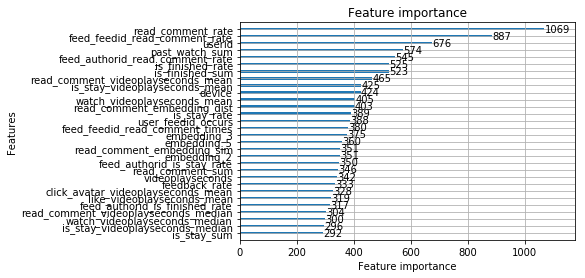

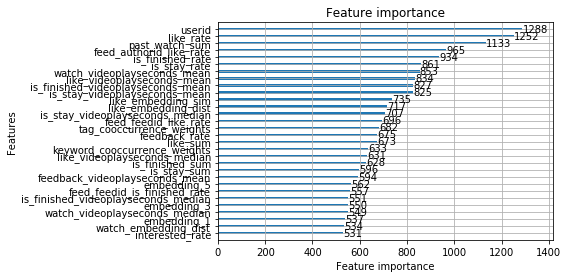

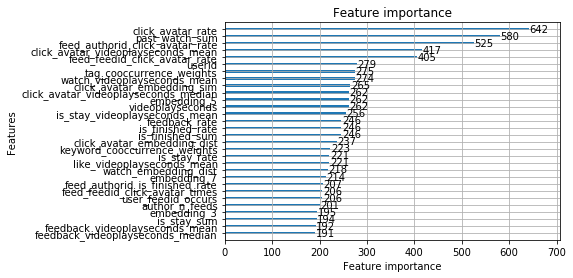

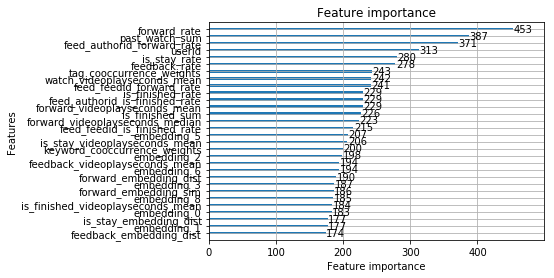

In [20]:
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import numpy as np




auc_sum = 0
bst_item = []
ul = val_df['userid'].tolist()
weight_label = [4,3,2,1]
for index, label in enumerate(['read_comment', 'like', 'click_avatar', 'forward']):
    label1 = train_label[label]
    dtrain = lgb.Dataset(train_df, label=label1)
    dval = lgb.Dataset(val_df, label=val_label[label].values)
    lgb_model = lgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        valid_sets=[dval],
        early_stopping_rounds=50,
        verbose_eval=50,
    )
    lgb.plot_importance(lgb_model, max_num_features=30, height=0.3)
    X_valid_pred = lgb_model.predict(val_df, num_iteration=lgb_model.best_iteration)
    bst_item.append(lgb_model.best_iteration)
    print(roc_auc_score(val_label[label], X_valid_pred))
    v = uAUC(val_label[label].tolist(), X_valid_pred.tolist(), ul)
    print(label, v)
    auc_sum = auc_sum + weight_label[index] * v / np.sum(weight_label)

print(auc_sum)

In [ ]:
original_test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_version2.csv'))

In [ ]:
User_Feed_Test = original_test_df[['userid', 'feedid']]

In [ ]:
Online_X_df = pd.concat([train_df, val_df])
Online_y_df = pd.concat([train_label, val_label])

In [ ]:
# bst_item = [73, 150, 55, 43]

for index, label in enumerate(['read_comment', 'like', 'click_avatar', 'forward']):
  label1 = Online_y_df[label]
  dtrain = lgb.Dataset(Online_X_df.values, label=label1)
  lgb_model = lgb.train(
      params,
      dtrain,
      num_boost_round=bst_item[index],
      valid_sets=[dtrain],
      early_stopping_rounds=50,
      verbose_eval=50,
  )
  X_test_pred = lgb_model.predict(test_df, num_iteration=lgb_model.best_iteration)
  User_Feed_Test[label] = X_test_pred


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.934517
[100]	training's auc: 0.936053
[150]	training's auc: 0.937413
[200]	training's auc: 0.938684
[250]	training's auc: 0.939712
[300]	training's auc: 0.94056
[350]	training's auc: 0.941374
[400]	training's auc: 0.942156
[450]	training's auc: 0.94289
[500]	training's auc: 0.943604
[550]	training's auc: 0.944297
[600]	training's auc: 0.944936
[650]	training's auc: 0.94554
[700]	training's auc: 0.946135
[750]	training's auc: 0.946705
[800]	training's auc: 0.947261
[850]	training's auc: 0.947805
[900]	training's auc: 0.948344
[950]	training's auc: 0.948819
[1000]	training's auc: 0.94934
[1050]	training's auc: 0.949854
[1100]	training's auc: 0.950318
[1150]	training's auc: 0.95081
Did not meet early stopping. Best iteration is:
[1153]	training's auc: 0.950843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.850158
[100]	training's auc: 0.854562
[150]	training's auc: 0.8584
[200]	training's auc: 0.861778
[250]	training's auc: 0.864493
[300]	training's auc: 0.866857
[350]	training's auc: 0.8692
[400]	training's auc: 0.871273
[450]	training's auc: 0.873271
[500]	training's auc: 0.875245
[550]	training's auc: 0.877241
[600]	training's auc: 0.879313
[650]	training's auc: 0.881195
[700]	training's auc: 0.882889
[750]	training's auc: 0.884493
[800]	training's auc: 0.886005
[850]	training's auc: 0.887599
Did not meet early stopping. Best iteration is:
[880]	training's auc: 0.888562
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.857573
[100]	training's auc: 0.865745
[150]	training's auc: 0.873209
[200]	training's auc: 0.880035
[250]	training's auc: 0.88595
[300]	training's auc: 0.891221
[350]	training's auc: 0.896277
[400]	training's auc: 0.901008
[450]	training's auc: 0.90513

In [ ]:
User_Feed_Test.to_csv('./lgb_result_{}.csv'.format(str(1234567)), index=False)